In [3]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append('./../../')
sys.path.append('./../../designer/script/')


from tmm.get_E import get_E_free
from tmm.get_jacobi_arb_adjoint import get_jacobi_E_free_form
from tmm.get_jacobi_adjoint import get_jacobi_adjoint
from tmm.get_spectrum import get_spectrum_free
from film import FreeFormFilm, TwoMaterialFilm
from tmm.autograd_wrapper import *
from tmm.E_to_spectrum import *

from optimizer.adam import AdamThicknessOptimizerAutograd

import matplotlib.pyplot as plt
import numpy as np
import copy
# set exp 
wls = np.linspace(300, 1500, 1000)

def run_exp(inc_ang=45., layer_number=20, avg_noise=5, steps=200, stepsize=1, layer_thickness=100, also_delta=False, wpsi=1, wdelta=1):
    inc_ang = inc_ang
    film = TwoMaterialFilm(2.5, 1.5, 2, np.random.random(layer_number) * layer_thickness)
    d = film.get_d()
    n_layers, n_sub, n_inc = film.calculate_n_array(wls), film.calculate_n_sub(wls), film.calculate_n_inc(wls)
    film.add_spec_param(inc_ang, wls)
    original_film = copy.deepcopy(film)

    target_film = TwoMaterialFilm(2.5, 1.5, 2, np.random.random(layer_number) * 2 * avg_noise + film.get_d())
    target_film.add_spec_param(inc_ang, wls)
    # E_target = np.zeros((wls.shape[0] * 2, 2), dtype='complex128')
    # get_E_free(
    #     E_target, 
    #     wls, 
    #     target_film.get_d(), 
    #     target_film.calculate_n_array(wls), 
    #     target_film.calculate_n_sub(wls), 
    #     target_film.calculate_n_inc(wls), 
    #     inc_ang, 
    # )
    # psi_target = E_to_Psi(E_target).cuda()
    if not also_delta:
        psi_target = torch.tensor(target_film.get_spec().get_tanPsi()).cuda().arctan()
        
        grad = torch.empty(film.get_layer_number())
        loss_fn = lambda E: (E_to_Psi(E) - psi_target).square().sum()
        grad_auto = get_jacobi_warpper(loss_fn)
        jacobi = np.zeros((wls.shape[0] * 4, film.get_d().shape[0], 2, 2))
    else:
        psi_target = torch.tensor(target_film.get_spec().get_tanPsi()).cuda().arctan()
        delta_target = torch.tensor(target_film.get_spec().get_delta()).cuda()
        loss_fn = lambda E: wpsi * (E_to_Psi(E) - psi_target).square().sum() + wdelta * torch.abs(E_to_ephase(E) - torch.exp(1j * delta_target)).square().sum()

    # for i in range(200):
    #     d = film.get_d()

    #     grad = grad_auto(    
    #         jacobi,
    #         wls,
    #         film.get_d(),
    #         n_layers,
    #         n_sub,
    #         n_inc,
    #         inc_ang,    
    #     )
        
    #     d = d - grad.cpu().numpy() * 0.1
    #     film.update_d(d)
    adam = AdamThicknessOptimizerAutograd(film, target_film.get_all_spec_list(), loss_fn, steps, alpha=stepsize)
    adam.optimize()
    return original_film, film, target_film




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
def plot(original_film, film, target_film, ax_psi, ax_delta, ax_d, show_d_mse=True):
    # test spectra
    target_psi = target_film.get_spec().get_tanPsi()
    tanpsi = film.get_spec().get_tanPsi()
    tanpsi_original = original_film.get_spec().get_tanPsi()

    target_delta = target_film.get_spec().get_delta()
    delta = film.get_spec().get_delta()
    delta_original = original_film.get_spec().get_delta()


    ax_psi.plot(wls, np.arctan(target_psi), label='Ground truth', c='C2', ls=':', zorder=1)
    ax_psi.plot(wls, np.arctan(tanpsi), label='Fit', c='C3', zorder=0)
    ax_psi.plot(wls, np.arctan(tanpsi_original), label='Before fit', c='C0', zorder=3, alpha=0.5)

    ax_delta.plot(wls, target_delta, label='Ground truth', c='C2', ls=':', zorder=1)
    ax_delta.plot(wls, delta, label='Fit', c='C3', zorder=0)
    ax_delta.plot(wls, delta_original, label='Before fit', c='C0', zorder=3, alpha=0.5)
    
    if ax_d is None:
        return
    # ax_d.pl
    if show_d_mse:
        ax_d.set_title(f'MSE: {np.sqrt(np.square(film.get_d() - target_film.get_d()).mean()): .1f}', y=0.92)

    x = np.arange(film.get_layer_number())  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    for f, name in zip([original_film, film, target_film], ['Before fit', 'After fit', 'Ground Truth']):
        offset = width * multiplier
        rects = ax_d.bar(np.arange(f.get_layer_number()) + offset, f.get_d(), width, label=name)
        # ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.

    # ax_d.set_title('')
    # ax_d.set_xticks(x + width, [f'{x:.0f}' for x in range(film.get_layer_number())])

# 
    # ax[1].plot(wls, np.angle(target_edelta), label='Ground truth', c='C2', ls=':', zorder=1)
    # ax[1].plot(wls, delta, label='Fit', c='C3', zorder=0)
    # ax[1].plot(wls, delta_original, label='Before fit', c='C0', zorder=3, alpha=0.5)
    

# inc_ang = 60.
# layer_number = 100
# original_film, film, target_film = run_exp(inc_ang=inc_ang, layer_number=layer_number, avg_noise=1, stepsize=0.1)

# ax = plt.figure().add_subplot()
# axd = plt.figure().add_subplot()
# plot(original_film, film, target_film, ax, axd)




In [20]:
inc_ang = 60.
layer_number = 10


films_ls = []
for i in range(16):
    r, c = i // 4, i % 4
    np.random.seed(i)

    original_film, film, target_film = run_exp(
        inc_ang=inc_ang, layer_number=layer_number, layer_thickness=100, avg_noise=3, steps=200, stepsize=0.1, also_delta=True, 
        wpsi=1, wdelta=1, 
    )
    films_ls.append([original_film, film, target_film])



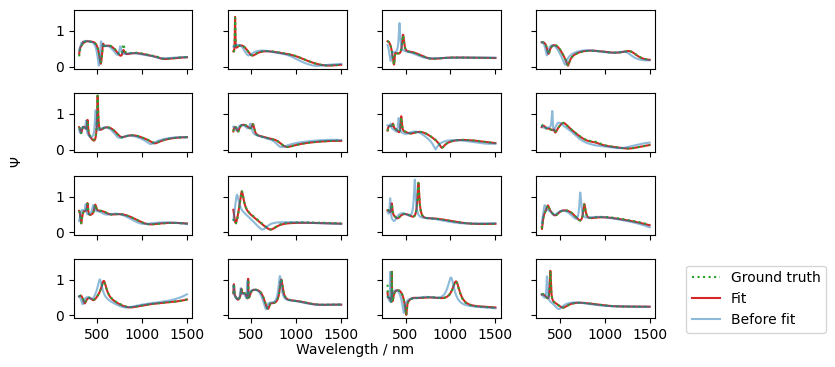

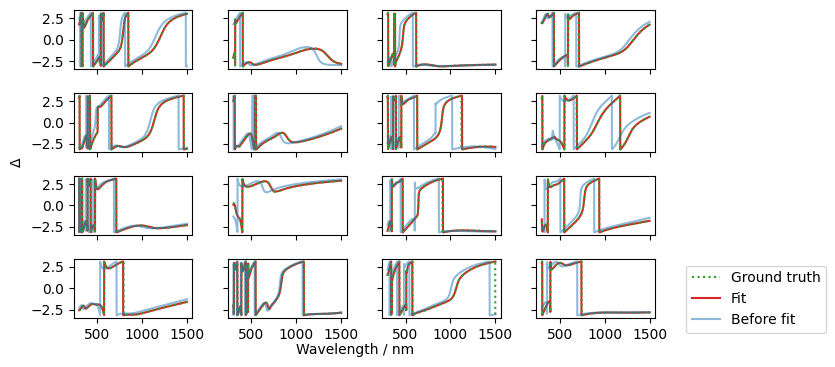

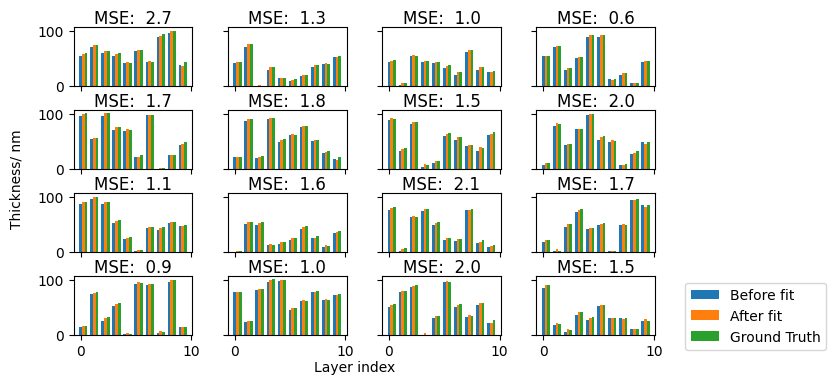

In [7]:

fig_psi, axes_psi = plt.subplots(4, 4, sharex=True, sharey=True)
fig_delta, axes_delta = plt.subplots(4, 4, sharex=True, sharey=True)
fig_d, axes_d = plt.subplots(4, 4, sharex=True, sharey=True)

for i, films in enumerate(films_ls):
    r, c = i // 4, i % 4
    plot(*films, axes_psi[r, c], axes_delta[r,c], axes_d[r, c])

fig_psi.text(0.5, 0.02, 'Wavelength / nm', ha='center')
fig_psi.text(0.04, 0.5, '$\Psi$', va='center', rotation='vertical')
axes_psi[3, 3].legend(loc='upper right', bbox_to_anchor=(2.5, 1))
fig_psi.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)
fig_psi.set_size_inches(7.5, 4)
fig_psi.savefig(f'{inc_ang}deg_{layer_number}layers_psi.png', dpi=300, bbox_inches='tight')

fig_delta.text(0.5, 0.02, 'Wavelength / nm', ha='center')
fig_delta.text(0.04, 0.5, '$\Delta$', va='center', rotation='vertical')
axes_delta[3, 3].legend(loc='upper right', bbox_to_anchor=(2.5, 1))
fig_delta.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)
fig_delta.set_size_inches(7.5, 4)
fig_delta.savefig(f'{inc_ang}deg_{layer_number}layers_delta.png', dpi=300, bbox_inches='tight')

fig_d.text(0.5, 0.02, 'Layer index', ha='center')
fig_d.text(0.04, 0.5, 'Thickness/ nm', va='center', rotation='vertical')
axes_d[3, 3].legend(loc='upper right', bbox_to_anchor=(2.5, 1))
fig_d.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)
fig_d.set_size_inches(7.5, 4)
fig_d.savefig(f'{inc_ang}deg_{layer_number}layers_d.png', dpi=300, bbox_inches='tight')

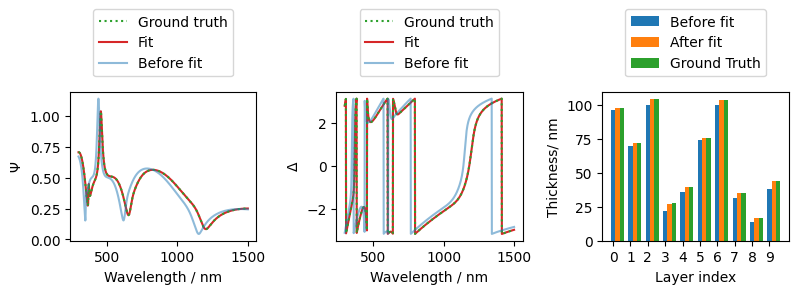

In [35]:
inc_ang = 60.
layer_number = 10

fig, (ax_psi, ax_delta, ax_d) = plt.subplots(1, 3, sharex=False, sharey=False)
fig.set_size_inches(8, 4)

torch.manual_seed(0)
np.random.seed(24)

original_film, film, target_film = run_exp(inc_ang=inc_ang, layer_number=layer_number, layer_thickness=100, avg_noise=3, steps=1000, stepsize=0.1)
plot(original_film, film, target_film, ax_psi, ax_delta, ax_d, show_d_mse=False)
ax_psi.set_xlabel('Wavelength / nm')
ax_psi.set_ylabel('$\Psi$')
ax_psi.legend(loc='upper center', bbox_to_anchor=(0.5, 1.6))

ax_delta.set_xlabel('Wavelength / nm')
ax_delta.set_ylabel('$\Delta$')
ax_delta.legend(loc='upper center', bbox_to_anchor=(0.5, 1.6))

ax_d.set_xlabel('Layer index')
ax_d.set_xticks(list(range(10)))
ax_d.set_ylabel('Thickness/ nm')
ax_d.legend(loc='upper center', bbox_to_anchor=(0.5, 1.6))

fig.tight_layout()
fig.savefig(f'./single_example_d.png', bbox_inches='tight', dpi=300)

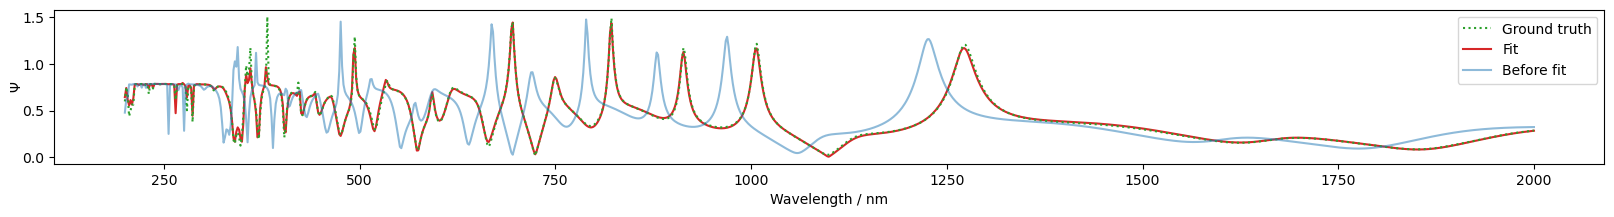

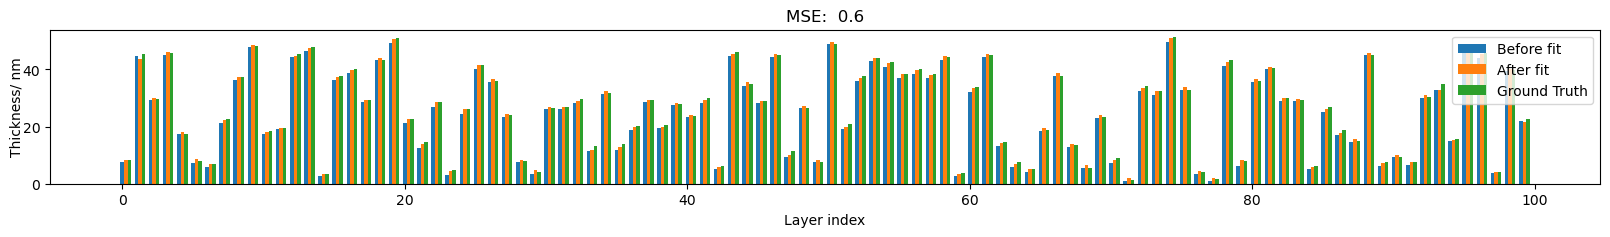

In [57]:
inc_ang = 60.
layer_number = 100

fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
fig_d, axes_d = plt.subplots(1, 1, sharex=True, sharey=True)

np.random.seed(233)

original_film, film, target_film = run_exp(inc_ang=inc_ang, layer_number=layer_number, layer_thickness=50, avg_noise=1, steps=1000, stepsize=0.1)
plot(original_film, film, target_film, axes, axes_d)

axes.set_xlabel( 'Wavelength / nm', ha='center')
axes.set_ylabel('$\Psi$', va='center', rotation='vertical')

axes_d.set_xlabel( 'Layer index', ha='center')
axes_d.set_ylabel('Thickness/ nm', va='center', rotation='vertical')

axes.legend(loc='upper right', bbox_to_anchor=(1, 1))
axes_d.legend(loc='upper right', bbox_to_anchor=(1, 1))

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
fig.set_size_inches(20, 2)
fig.savefig(f'{inc_ang}deg_{layer_number}layers.png', dpi=300, bbox_inches='tight')


fig_d.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
fig_d.set_size_inches(20, 2)
fig_d.savefig(f'{inc_ang}deg_{layer_number}layers_d.png', dpi=300, bbox_inches='tight')

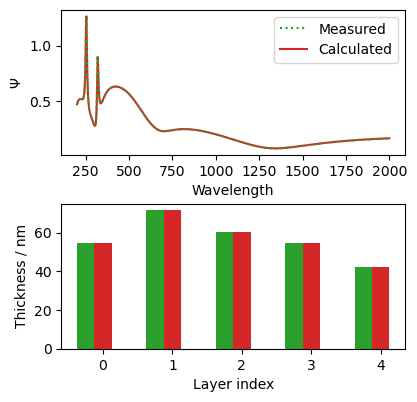